I receive allowances for written work in line with my individual support plan (disability allowance) - 201405384

__Are there more potholes in more deprived areas of Glasgow?__

Both the public and policy makers often assume that there is a clear link between an areas level of deprivation and quality of infrastructure, for example standard of roads and pavements. This report uses Scottish open source data to explore whether or not there is a correlation between these variables, to see if policy makers need to push to improve everyday quality of life for citizens residing in these more deprived areas of Glasgow.

__Importing Data__

In [66]:
#Import required packages 

#For visualisations 
import seaborn as sns
import matplotlib.pyplot as plt

#For data manipulation
import pandas as pd
import numpy as np
import geopandas as gpd

#For Statistical Modelling and Machine learning 

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

import geoplot as gplt
import geoplot.crs as gcrs

In [67]:
import warnings
warnings.filterwarnings('ignore')

Below we introduce two sources of open data. Firstly, Scottish street data (2023), which is a dataset sourced from the Urban Big Data Centre that includes a collection of all reports made within the Glasgow area regarding presence of pavements, footpaths and issues with potholes. The second dataset includes a Scotland wide Index of Multiple Deprivation collected in 2020, procured through the Consumer Data Research Centre (CDRC database).

In [68]:
#Read in Scottish street and deprivation data 
StreetData = pd.read_csv("ScottishStreetData.csv")
ScottishIMD = pd.read_csv("ScottishIMD.csv")

In [69]:
#Initial exploration of both datasets to make sure they have loaded in correctly 
StreetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3958 entries, 0 to 3957
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   category   3958 non-null   object 
 1   latitude   3958 non-null   float64
 2   longitude  3958 non-null   float64
 3   datazone   3958 non-null   object 
 4   name       3958 non-null   object 
dtypes: float64(2), object(3)
memory usage: 154.7+ KB


In [70]:
ScottishIMD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Data_Zone                        6976 non-null   object 
 1   Intermediate_Zone                6976 non-null   object 
 2   Council_area                     6976 non-null   object 
 3   Total_population                 6976 non-null   int64  
 4   Working_Age_population           6976 non-null   int64  
 5   SIMD2020v2_Rank                  6976 non-null   int64  
 6   SIMD_2020v2_Percentile           6976 non-null   int64  
 7   SIMD2020v2_Vigintile             6976 non-null   int64  
 8   SIMD2020v2_Decile                6976 non-null   int64  
 9   SIMD2020v2_Quintile              6976 non-null   int64  
 10  SIMD2020v2_Income_Domain_Rank    6976 non-null   float64
 11  SIMD2020_Employment_Domain_Rank  6976 non-null   float64
 12  SIMD2020_Health_Doma

Below explores the spatial feature of both datasets, this being the 'datazone' and 'Data_Zone'. It is important to ensure that both variables, in this case 'datazone', are displayed in the same format to guarantee they can be mapped once merged appropriately.

In [71]:
#Checking spatial feature of data set to make sure both variables are formatted the same and can be mapped 
StreetData['datazone']

0       S01009815
1       S01010391
2       S01010391
3       S01010379
4       S01009797
          ...    
3953    S01009851
3954    S01010053
3955    S01009804
3956    S01010117
3957    S01009888
Name: datazone, Length: 3958, dtype: object

In [72]:
ScottishIMD['Data_Zone']

0       S01006506
1       S01006507
2       S01006508
3       S01006509
4       S01006510
          ...    
6971    S01013477
6972    S01013478
6973    S01013479
6974    S01013480
6975    S01013481
Name: Data_Zone, Length: 6976, dtype: object

__Data Cleaning__

The street data includes mulitple categories, many of which for this report are irrelevant. It is then important to thoroughly clean the data and remove excess categories and in this case only keep the data regarding pothole count. The new dataset is then briefly explored, in order to make sure the first part of the cleaning process was successfull.

In [73]:
#Clean pothole data (Keeping only potholes in category)
StreetData.loc[StreetData["category"]=='Potholes']

#Create new data set (Potholes) for potholes only 
Potholes = StreetData[(StreetData['category']== 'Potholes')]

In [74]:
#Exploration of new dataset 
Potholes.head()

,category,latitude,longitude,datazone,name
0,Potholes,55.84409,-4.34629,S01009815,Cardonald West and Central - 01
2,Potholes,55.87056,-4.32029,S01010391,Glasgow Harbour and Partick South - 04
3,Potholes,55.87254,-4.28755,S01010379,Kelvingrove and University - 06
4,Potholes,55.82028,-4.36781,S01009797,Pollok South and West - 06
5,Potholes,55.85509,-4.34113,S01009836,Drumoyne and Shieldhall - 04


In [75]:
Potholes.tail()

,category,latitude,longitude,datazone,name
3947,Potholes,55.82215,-4.37897,S01009793,Pollok South and West - 02
3948,Potholes,55.81172,-4.33927,S01009782,Nitshill - 08
3950,Potholes,55.87842,-4.27847,S01010307,Firhill - 07
3951,Potholes,55.86728,-4.23603,S01010262,City Centre East - 04
3952,Potholes,55.88295,-4.30497,S01010412,Kelvinside and Jordanhill - 05


In [76]:
Potholes

,category,latitude,longitude,datazone,name
0,Potholes,55.84409,-4.34629,S01009815,Cardonald West and Central - 01
2,Potholes,55.87056,-4.32029,S01010391,Glasgow Harbour and Partick South - 04
3,Potholes,55.87254,-4.28755,S01010379,Kelvingrove and University - 06
4,Potholes,55.82028,-4.36781,S01009797,Pollok South and West - 06
5,Potholes,55.85509,-4.34113,S01009836,Drumoyne and Shieldhall - 04
...,...,...,...,...,...
3947,Potholes,55.82215,-4.37897,S01009793,Pollok South and West - 02
3948,Potholes,55.81172,-4.33927,S01009782,Nitshill - 08
3950,Potholes,55.87842,-4.27847,S01010307,Firhill - 07
3951,Potholes,55.86728,-4.23603,S01010262,City Centre East - 04


Due to the fact we are exploring whether or not there are more potholes in more deprived areas, another cleaning step is needed. Using the .groupby() function, one can aggregate up to a higher geography area and group the number of potholes by specific datazone, instead of individual potholes.

In [77]:
#Need to aggregate up to geography area and group by datazone 
grouped_data = Potholes.groupby('datazone')['category'].sum()

In [78]:
potholes_by_datazone = Potholes.groupby('datazone')

potholes_count_by_datazone = potholes_by_datazone.size().reset_index(name='pothole_count')

In [79]:
#Explore
potholes_count_by_datazone.head()

,datazone,pothole_count
0,S01009758,12
1,S01009759,1
2,S01009760,21
3,S01009761,10
4,S01009762,1


In [80]:
potholes_count_by_datazone

,datazone,pothole_count
0,S01009758,12
1,S01009759,1
2,S01009760,21
3,S01009761,10
4,S01009762,1
...,...,...
612,S01010497,4
613,S01010499,5
614,S01010500,3
615,S01010501,2


The dataset is sorted descending in value, this is a good step in order to view the dataset in a more orderly fashion. Here we can see the maxiumum and minimum values with corresponding datazones.

In [81]:
#View data set in order to see highest value of pothole
potholes_count_by_datazone_sorted = potholes_count_by_datazone.sort_values('pothole_count', ascending=False)

In [82]:
potholes_count_by_datazone_sorted

,datazone,pothole_count
238,S01010032,60
8,S01009767,50
239,S01010033,48
65,S01009833,39
437,S01010275,36
...,...,...
160,S01009939,1
162,S01009941,1
430,S01010268,1
270,S01010066,1


Kumar and Khosla (2018) comment on the importance of checking for null values that could alter analysis of data. The .isnull() function is used to display any missing data and null values within a dataset. 

In [83]:
# Check for missing values in the entire dataframe
print(potholes_count_by_datazone_sorted.isnull().sum())


datazone         0
pothole_count    0
dtype: int64


After doing intial cleaning on the two open source datasets, we introduce a shapefile of the scottish country with datazone boundaries.

In [84]:
#Introduce Scottish Shapefile for spatial aspect 
gdf = gpd.read_file("/Scotland_dz_2011/scotland_dz_2011.shp")


In [85]:
#Initial exploration of the data 
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datazone    6976 non-null   object  
 1   name        6976 non-null   object  
 2   totpop2011  6976 non-null   int64   
 3   respop2011  6976 non-null   int64   
 4   hhcnt2011   6976 non-null   int64   
 5   stdareaha   6976 non-null   float64 
 6   stdareakm2  6976 non-null   float64 
 7   shape_leng  6976 non-null   float64 
 8   shape_area  6976 non-null   float64 
 9   code        6976 non-null   object  
 10  label       6976 non-null   object  
 11  geometry    6976 non-null   geometry
dtypes: float64(4), geometry(1), int64(3), object(4)
memory usage: 654.1+ KB


In [86]:
gdf.head()

,datazone,name,totpop2011,respop2011,hhcnt2011,stdareaha,stdareakm2,shape_leng,shape_area,code,label,geometry
0,S01006506,Culter - 01,872,852,424,438.880218,4.388801,11801.872345,4.388802e+06,S01006506,S12000033S01006506,"POLYGON ((383285.265 800510.607, 383348.492 80..."
1,S01006507,Culter - 02,836,836,364,22.349739,0.223498,2900.406362,2.217468e+05,S01006507,S12000033S01006507,"POLYGON ((383527.919 801536.276, 383541.089 80..."
2,S01006508,Culter - 03,643,643,340,27.019476,0.270194,3468.761949,2.701948e+05,S01006508,S12000033S01006508,"POLYGON ((383473.000 801227.000, 383597.000 80..."
3,S01006509,Culter - 04,580,580,274,9.625426,0.096254,1647.461389,9.625426e+04,S01006509,S12000033S01006509,"POLYGON ((383976.659 801182.579, 383984.102 80..."
4,S01006510,Culter - 05,644,577,256,18.007657,0.180076,3026.111412,1.800766e+05,S01006510,S12000033S01006510,"POLYGON ((384339.000 801211.000, 384316.510 80..."


In [87]:
#Check for null values within dataframe
print(gdf.isnull().sum())

datazone      0
name          0
totpop2011    0
respop2011    0
hhcnt2011     0
stdareaha     0
stdareakm2    0
shape_leng    0
shape_area    0
code          0
label         0
geometry      0
dtype: int64


<Axes: >

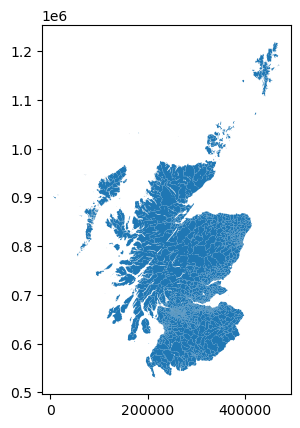

In [88]:
#Plot spatial data to check it works 
gdf.plot()

In order to visualise number of potholes per datazone, the dataframes (scotland shapefile (gdf) and pothole_by_datazone) must be merged. This was executed through a right join to avoid any null values.

In [89]:
#Merging spatial data and pothole data using a right join
pothole_datazone = pd.merge(gdf, potholes_count_by_datazone_sorted, left_on='datazone', right_on='datazone', how='right')

It is in good practice to briefly explore any merged dataset, to ensure the merging has been successful.

In [90]:
#Explore dataframe to check whether the merge has occured correctly 
pothole_datazone.head()

,datazone,name,totpop2011,respop2011,hhcnt2011,stdareaha,stdareakm2,shape_leng,shape_area,code,label,geometry,pothole_count
0,S01010032,Laurieston and Tradeston - 02,840,518,298,88.413310,0.884133,6315.613692,8.841331e+05,S01010032,S12000046S01010032,"POLYGON ((258660.100 664747.900, 258722.800 66...",60
1,S01009767,Darnley North - 04,557,509,227,306.940400,3.069404,17004.466933,3.069404e+06,S01009767,S12000046S01009767,"POLYGON ((251933.615 659315.358, 252012.329 65...",50
2,S01010033,Laurieston and Tradeston - 03,923,905,503,54.793123,0.547932,5610.276009,5.479312e+05,S01010033,S12000046S01010033,"POLYGON ((258999.837 663860.613, 259003.420 66...",48
3,S01009833,Drumoyne and Shieldhall - 01,555,525,238,205.365365,2.053654,9440.500814,2.053654e+06,S01009833,S12000046S01009833,"POLYGON ((252807.900 666904.200, 252808.700 66...",39
4,S01010275,City Centre South - 04,600,592,357,53.074103,0.530740,5870.678018,5.307410e+05,S01010275,S12000046S01010275,"POLYGON ((259186.167 665808.509, 259165.741 66...",36


In [91]:
pothole_datazone.tail()

,datazone,name,totpop2011,respop2011,hhcnt2011,stdareaha,stdareakm2,shape_leng,shape_area,code,label,geometry,pothole_count
612,S01009939,Carnwadric West - 01,901,901,521,4.057744,0.040577,1249.036617,40577.463932,S01009939,S12000046S01009939,"POLYGON ((254572.835 660203.072, 254573.000 66...",1
613,S01009941,Carnwadric West - 03,1033,1033,320,14.776129,0.147761,2150.524727,147761.298322,S01009941,S12000046S01009941,"POLYGON ((254994.608 660060.515, 254987.766 66...",1
614,S01010268,City Centre West - 03,831,728,417,4.488563,0.044885,1309.153758,44885.628234,S01010268,S12000046S01010268,"POLYGON ((258300.785 666259.278, 258357.122 66...",1
615,S01010066,Braidfauld - 06,753,753,342,9.246328,0.092464,1808.411036,92463.274952,S01010066,S12000046S01010066,"POLYGON ((263104.000 663470.999, 263086.000 66...",1
616,S01009975,Glenwood South - 03,800,800,398,14.677255,0.146774,2099.270999,146772.547523,S01009975,S12000046S01009975,"POLYGON ((260048.683 658786.395, 260057.787 65...",1


A simple histogram plot was created using the .hist() function, just as a simple way to view the inital distribution of the data. Here one can see a clear story. Far more datazones have fewer potholes within them compared to datazones with 15+ potholes reported within them. 

<Axes: >

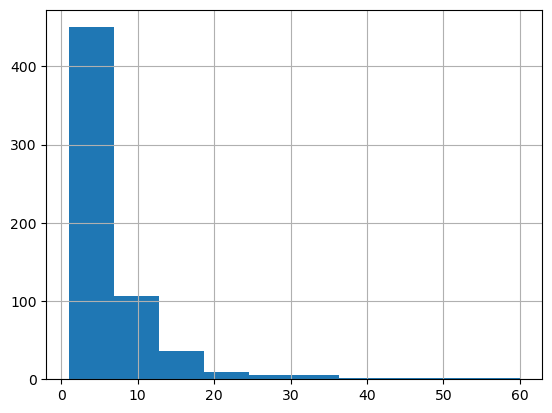

In [92]:
#Initial exploration to see skew of data
pothole_datazone['pothole_count'].hist()

In [93]:
#Futher exploration (solidify what can be seen in the histogram)
pothole_datazone['pothole_count'].min()

1

In [94]:
pothole_datazone['pothole_count'].max()

60

In [95]:
pothole_datazone['pothole_count'].mean()

5.706645056726094

Text(0.5, 1.05, 'Pothole Count in Glasgow by Datazone')

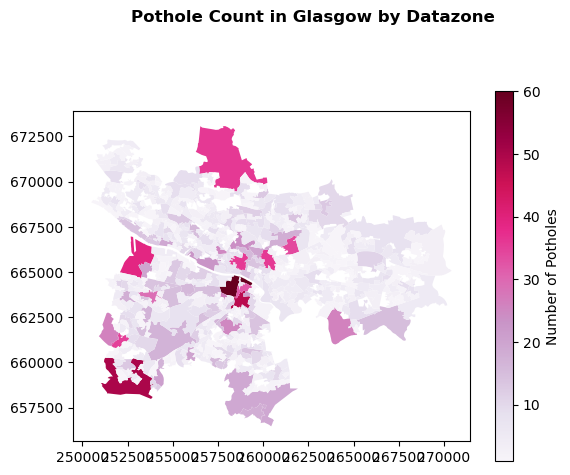

In [96]:
#Initial plot of number of potholes by datazone 
pothole_datazone.plot('pothole_count', legend= True, cmap = 'PuRd', legend_kwds= {'label': "Number of Potholes"})

plt.suptitle("Pothole Count in Glasgow by Datazone", fontweight='bold', fontsize=12, y=1.05)

Now that the first dataset cleaning is complete and a draft plot looks correct, one can continue cleaning the Mulitple Deprivation set for the other half of the first visualisation. Only the 'SIMD2020v2_Decile' column is needed along with the 'datazone' for mapping purposes. Below the mulitple deprivation column is subsetted to only include relevant columns. 

In [97]:
#Adding in the deprivation variable

#Looking for the relevant column within Deprivation data frame 
ScottishIMD.SIMD2020v2_Decile.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6976 entries, 0 to 6975
Series name: SIMD2020v2_Decile
Non-Null Count  Dtype
--------------  -----
6976 non-null   int64
dtypes: int64(1)
memory usage: 54.6 KB


In [98]:
#Subsetting to only view the relevant columns)
IMD = pd.DataFrame({
    'Datazone': ScottishIMD['Data_Zone'],
    'Deprivation': ScottishIMD['SIMD2020v2_Decile']
})

In [99]:
#Check that subsetting has worked 
IMD.head()

,Datazone,Deprivation
0,S01006506,7
1,S01006507,7
2,S01006508,9
3,S01006509,7
4,S01006510,6


In [100]:
IMD.tail()

,Datazone,Deprivation
6971,S01013477,4
6972,S01013478,6
6973,S01013479,3
6974,S01013480,5
6975,S01013481,8


__Visualisation One - Spatial__ 

Merging the geospatial shapefile with the deprivation dataset using an inner join was made to avoid null values. When left or right joins were attempted, the columns produced did not merge correctly and or were full of missing values. 

In [101]:
#Merge Deprivation dataset with spatial shapefile to get a map of whole dataset
IMD_merged = pd.merge(gdf, IMD, left_on='datazone', right_on='Datazone', how='inner')

The newly merged dataset (IMD-merged) was then plotted. As you can see, due to the fact that the IMD data is Scotland wide, the intial plot for multiple deprivation includes data for the whole of scotland.

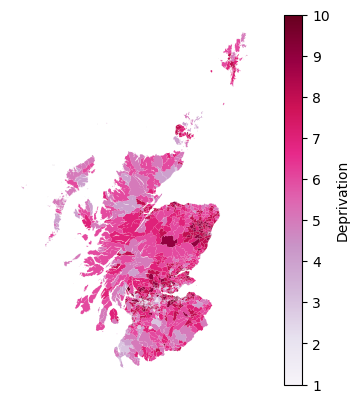

In [102]:
IMD_merged.plot('Deprivation', legend= True, cmap = 'PuRd', legend_kwds= {'label': "Deprivation"}).set_axis_off()

Therefore, further subsetting and cleaning in necessary. Here the original scottish geospatial shapefile is subsetted to only include the 'datazones' that also appear within the street data (pothole_datazone).

In [103]:
#Subset the whole country to simple the datazones that are used in the pothole dataframe (just glasgow)
subsetted_gdf = gdf[gdf['datazone'].isin(pothole_datazone['datazone'])]

The plot below is obviously innacurate in terms of deprivation but it acts as a simple check to see if the subsetting was successful.

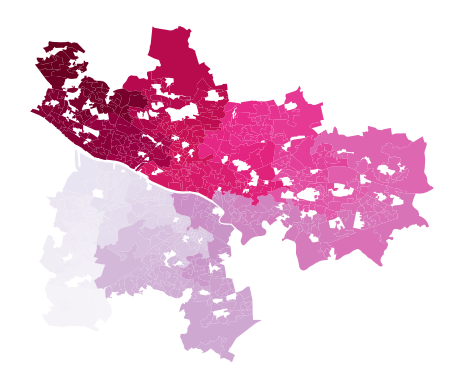

In [104]:
#View (obviously this is not accurate as it is just plotting the datazones)
subsetted_gdf.plot('datazone', legend= False, cmap = 'PuRd').set_axis_off()

The final data preparation and merging stage is merging the subsetted shapefile with the subsetted multiple deprivation dataset to create a dataset that only includes deprivation in only glasgow datazones (Onlyglasgowdep).

In [105]:
#Further merge of dataframes to include only glasgow datazones
Onlyglasgowdep = pd.merge(IMD_merged, subsetted_gdf, left_on='datazone', right_on='datazone', how='inner')

A plotting issue arose regarding geometry columns not being set and or present in the new dataset, making plotting the spatial aspect impossible. The line of code below manually sets the geometry column within the dataframe in order to plot the spatial aspect.

In [106]:
#Need to set a geometry column within dataframe in order to plot the spatial aspects
Pothole_IMD_Final = Onlyglasgowdep.set_geometry('geometry_x') 

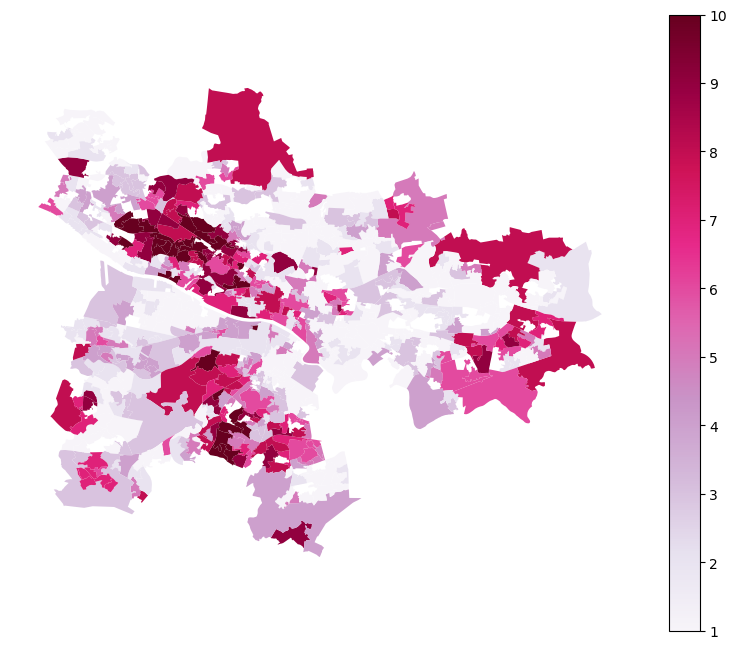

In [107]:
#Check that merge has worked and the data plots correctly by datazone
fig, ax = plt.subplots(figsize=(10, 8))
Pothole_IMD_Final.plot(ax=ax, column='Deprivation', legend=True, cmap='PuRd')
ax.set_axis_off()
plt.show()

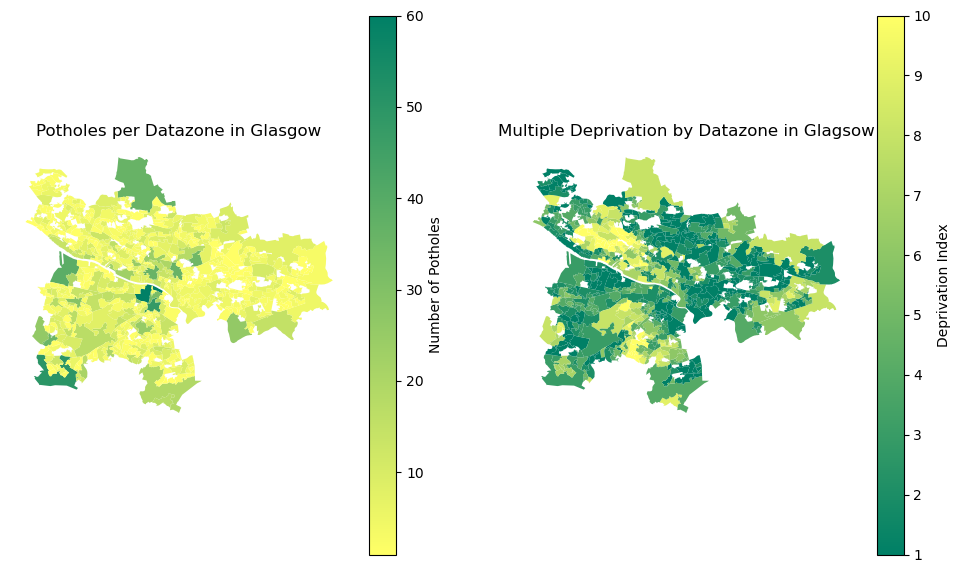

In [108]:
# create a figure with two subplots (maps) 
f,ax = plt.subplots(1,2, figsize=(12,7))

#plot both maps 
pothole_datazone.plot(ax=ax[0], column= 'pothole_count', legend= True, cmap = 'summer_r', legend_kwds= {'label': "Number of Potholes"})

Pothole_IMD_Final.plot(ax=ax[1], column='Deprivation', legend=True, cmap='summer', legend_kwds= {'label': "Deprivation Index"})


# give subplot 1 an informative title
ax[0].set_title('Potholes per Datazone in Glasgow')

# give subplot 2 an informative title
ax[1].set_title('Multiple Deprivation by Datazone in Glagsow')


# make axis invisible for subplot 1
ax[0].set_axis_off()

# make axis invisible for subplot 2
ax[1].set_axis_off()


plt.show()

The visualisation above shows two static spatial maps that together tell a story about the relationship between the number of potholes and multiple deprivation across zones in Glasgow, Scotland. Firstly, addressing the visual aspects and the logisctics of this visualisation. Creating a figure that includes two subplots side-by-side enhances readibility for the audience. Both axis grids were changed to be hidden in order to prevent diversion from the visualisation as they do not contribute any relevant details. Appropriate titles for each plot were added above each map. Variable names on the axis were altered from the original dataframe column names to make it as clear as possible for the reader. The "summer" colourscheme was chosen as it is colourblind friendly. It is also ideal an ideal sequencial colourscheme to show the range of 1-60 potholes, the darker shade implying higher frequency of reported potholes. For this reason the colour scheme was reversed, "summer_r", due to the fact 1 is the lowest rank on the scale (higher rates of deprivation). Instead of the more traditional approach of 'higher equals more'. Reversing this scale was a concious decision to avoid any confusion for the audience. 

Douglas Pigg (2001) commented on a new neighbourhood agenda being "from potholes to poverty". Highlighting doing the 'ordinary' jobs, filling potholes for example, even in the most deprived zones can help improve overall quality of life. Alphonsus, Waldner and Fuller (2018) explored vehicle collisions in areas ranging in deprivation scores. They found in the prescence of potholes, the odds of an accident in more deprived areas is 2.6 times higher than in the less deprived counterparts (Alphonsus, Waldner and Fuller (2018). This is why looking at the relationship between depravity and potholes is important for policymakers, as it could help not only improve quality of life but also safety of residents of both deprived and non-deprived areas.

On first glance a relationship between the two variables seems unlikely, however upon further inspection a few points can be disected. A standout pocket of lower deprivation (8-10) in the north-west of Glasgow looks very similar on the other half of the subplot, with very low number of reported potholes. The few datazones near the centre of Glasgow that have significantly higher numbers of reported potholes are also reflected on the right and are located in areas of lower ranking deprivation scores (1-3). The same can be said for the datazone located on the south-western tip of Glasgow, it has a IMD index ranking of 2 along with between 50-60 potholes. An anomaly for this is the most northern datazone in Glasgow that is far less deprived (8) than its surrounding datazones (1 and 2), however it has significantly higher numbers of reported potholes.

__Visualisation Two - Non-Spatial__

In [109]:
#Making OLS Regression model
X = Pothole_IMD_Final['Deprivation']  # Independent variable (Deprivation index)
y = pothole_datazone['pothole_count']  # Dependent variable (Number of potholes)

# Adding a constant term to the independent variable
X = sm.add_constant(X) 
# Perform ordinary least squares regression
model = sm.OLS(y, X).fit()  
# Show model summary 
print(model.summary())  


                            OLS Regression Results                            
Dep. Variable:          pothole_count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.470
Date:                Tue, 12 Dec 2023   Prob (F-statistic):             0.0630
Time:                        14:09:54   Log-Likelihood:                -2034.6
No. Observations:                 617   AIC:                             4073.
Df Residuals:                     615   BIC:                             4082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.3683      0.443     14.391      

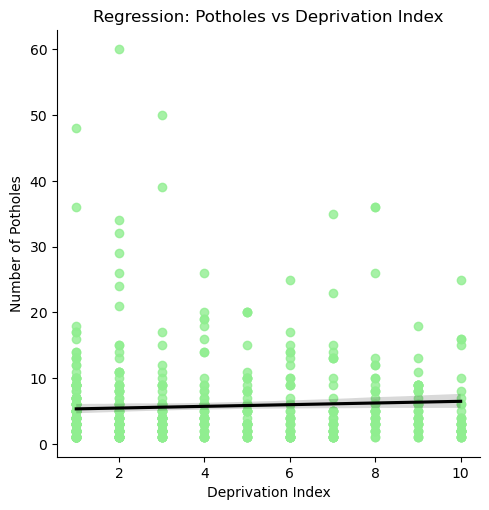

In [110]:
#Visualisation of Regression
# Merge the two dataframes
merged_df = pd.merge(pothole_datazone, Pothole_IMD_Final, on='datazone')

# Plotting a scatter plot, including a clear regression line
sns.lmplot(x='Deprivation', y='pothole_count', data=merged_df, line_kws={'color': 'black'}, scatter_kws={'color': 'lightgreen', 'marker': 'o'})
plt.title('Regression: Potholes vs Deprivation Index')
plt.xlabel('Deprivation Index')
plt.ylabel('Number of Potholes')
plt.show()


The second visualisation which is non-spatial and consists of a regression analysis between the two variables being studied in order to solidify any potential relationships, providing statistical evidence (that can be seen in written form in the model results above). An appropriate title was added along with axis labels that have been altered from the original dataset column names for ease of audience reading. The colour of the markers were also changed from the default colours to make the regression line stand out even more. 

By simply looking at the scatterplot above, a relationship is difficult to infer. However when analysing the regression line, one can almost assume there is a ever so slight negative correlation. The lines gradient increases as the deprivation index increases, more potholes are reported in areas over lower ranking deprivation scores (8-10). Upon reviewing the OLS (Ordinary Least Squares) model outcomes, the assumption above could be backed up by the deprivation variable coefficient (-0.1669), suggesting a negative relationship between number of potholes in a datazone and deprivation index score. However, the p-value that is associated with this variable was 0.063, which is below the level of significance (p<0.05), this indicates that the relationship between the variables is not statistically significant. To enhance this model in the future, one could include additional variables that could have an influence on the number of potholes in a designated zone such as; weather conditions, road maintenance and geographic factors. Adding these other variables could increase the predictablity and reliablilty of the model.

Although a significant correlation cannot be observed in this particular relationship, this type of investigation using open source data is simple, cost-effective, fast method for identifying vulnerable areas and could encourage policymakers to help improve quality of life in these areas. 

__References__

Alphonsus, K.B., Waldner, C. and Fuller, D. (2018). Examining the association between area level deprivation and vehicle collisions that                                result in injury. Canadian Journal of Public Health = Revue Canadienne de Santé Publique, 109(1), pp.43–51.                                  doi:https://doi.org/10.17269/s41997-018-0036-7.

Consumer Data Research Centre (CDRC), Scottish Index of Multiple Deprivation (IMD) 2020
                           URL: https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd/resource/scottish-imd-2020-v2
                           Accessed Date: December, 2023

Kumar and Khosla (2018). Data Cleaning-A Thorough Analysis and Survey on Unstructured Data | IEEE Conference Publication | IEEE Xplore.                                 ieeexplore.ieee.org.

Pigg, D. (2001). Funding and Procurement, Proving the link—from potholes to poverty. Proceedings of the Institution of Civil Engineers -                                Municipal Engineer, 145(3), pp.247–250.

Scottish Street Data(2023), Fix My Street Data Glasgow UK to 2017. University of Glasgow.
                           URL: https://data.ubdc.ac.uk/dataset/fms-glasgow-to-2017
                           Accessed Date: December, 2023

